In [68]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import shap

# define variables
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
compression_extension = ".gz"

metropole_appartement_file = "ventes-metropole-appartement" + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_V1_clean_" + parquet_extension

acp_appartement_file = "df_ACP_IRIS_immo_Processed"  + parquet_extension

app_model_data_file = "ventes-metropole-model-appartement" 

app_shap_explainer_file = "shap-explainer"

DROP_COLUMNS = ['prix_bien','date',"expo_double","CODE_IRIS"]

ModelNames = ["XGBRegressor", "DecisionTreeRegressor"]

# set model option
SaveModelData = True
#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False

lgbRegressionON = False
XGBRegressorON = False
GridSearchXGBRegressor = False
GridSearchDecisionTree = False
XGBRegressorOpimizedON = True
DecisionTreeDisplay = True
ShapDisplay = True

DropRegDep = True
DropLoyer = True
AddACP = True

# # functions

In [ ]:
# functions  
import joblib
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import time

def print_numerical_isna(df) :
    columns = df.select_dtypes(include='number').columns.tolist()
    print (df[columns].isna().sum())

def print_categorial_isna(df) :
    columns = df.select_dtypes(include='category').columns.tolist()
    print (df[columns].isna().sum())     

def load_appartement_file (filename) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    return pd.read_parquet(final_path.as_posix())

def save_model_file (model,filename,comp_ext="") :
    start_path = Path(immo_vis_dir)
    final_path = start_path / (filename + comp_ext)
    print (f"save model filename {final_path.as_posix()}")
    if comp_ext == ".gz" :
        joblib.dump(model, final_path.as_posix(),compress=('gzip', 3))
    elif comp_ext == ".bz2" :
        joblib.dump(model, final_path.as_posix(),compress=('gzip', 3))
    else :
        joblib.dump(model, final_path.as_posix())
        
def load_model_file (filename,modelname,comp_ext="") :
    start_path = Path(immo_vis_dir)
    final_path = start_path / (filename + '-' + modelname + comp_ext)
    return joblib.load(final_path)

def save_appartement_file (df, filename,drop_columns = None) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    if drop_columns is None :
        df.to_parquet(path=final_path.as_posix(),index=True)
    else :
        df1 = df.drop(columns= drop_columns)
        df1.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]

def apply_scale_processing(operator,X_train,X_test):
    #Operator could be scaler or encode
    op=operator
    op.fit(X_train)
    X_train_treated=pd.DataFrame(op.transform(X_train),columns=X_train.columns)
    X_test_treated=pd.DataFrame(op.transform(X_test),columns=X_train.columns)
    return X_train_treated,X_test_treated

def apply_preprocessing  (df,target_column,drop_region=True,drop_loyer=True) :
    y_tmp =df[target_column]
    columns = [target_column]
    if drop_region :
        columns.append("DEP")
        columns.append("REG")
    if drop_loyer :
        columns.extend(['loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7'])
        
    X_tmp =df.drop(columns=columns)
    return X_tmp,y_tmp

def create_train_test_data (X ,y) :
    from sklearn.model_selection import train_test_split
    #  build the train and test data
    print (X.shape)
    return train_test_split(X,y,test_size=0.2,random_state=42)

def create_train_test_data_subset (X ,y,subset_size = 1.0) :
    from sklearn.model_selection import train_test_split
    #  build the train and test data
    print (X.shape)
    return train_test_split(X,y,test_size=0.2,train_size=subset_size, random_state=42)

# Load model files

In [41]:
# import appartement file

RegressionModels = {}
for model_name in ModelNames :
    RegressionModels[model_name] = load_model_file (filename=app_model_data_file,modelname=model_name,comp_ext=compression_extension)

In [31]:

       
ACPS = {"PC1": "1 Rural isolé  Vs Urbain dense",
        "PC2" : "2 Terr. déclinant Vs Résidentiel récent aisé",
        "PC3" : "3 Populaire Vs Etudes Sup + centre ville",
        "PC4" : "4 Acifs modestes  Vs Seniors résid. mer",
        "PC5" : "5 Résidentiel ancré Vs Récent en croissance",
        "PC6" : "6 Social Aisé Vs Délinquance centre  Hub",
        "PC7" : "7 Technopole Univ Vs STUP quartiers sensibles",
        "PC8" : "8 ZAC campus récent Vs Habitat trad. containt",
        "PC9" : "9 Stup evenement Vs Vols zones transit",
        "PC10" : "10 Petites communes dynamiques Vs déclinantes",
        "PC11" : "11 Urbain en déclin Vs Agricole en dévpt",
        "PC12" : "12 Commune dépendante Agglo Vs Commune autonome",
        "PC13" : "13 Communes du litoral commercantes",
        "PC14" : "14 Infrast rurales Vs Village tourist. ancien",
        "PC15" : "PC15",
        "PC16" : "PC16",
        "PC17" : "PC17",
        "PC18" : "PC18",
        "PC19" : "PC19",
        "PC20" : "PC20",
        "CODE_IRIS" : "CODE_IRIS"
       }


# Load data

In [42]:
df = load_appartement_file (app_model_data_file)
print (df.shape)
print (df.info())

(2077476, 60)
<class 'pandas.core.frame.DataFrame'>
Index: 2077476 entries, 0 to 2077475
Data columns (total 60 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   etage                                            int64  
 1   surface                                          int64  
 2   nb_pieces                                        int64  
 3   balcon                                           int64  
 4   eau                                              int64  
 5   bain                                             int64  
 6   annonce_exclusive                                int64  
 7   nb_etages                                        float64
 8   places_parking                                   float64
 9   cave                                             int64  
 10  annee_construction                               float64
 11  nb_toilettes                                     int64  
 12  nb_te

# # Preprocessing

In [43]:
# set target and data
print (df.columns)
target_column= 'prix_m2_vente'
X,y = apply_preprocessing(df, target_column=target_column)
display(X)


Index(['etage', 'surface', 'nb_pieces', 'balcon', 'eau', 'bain',
       'annonce_exclusive', 'nb_etages', 'places_parking', 'cave',
       'annee_construction', 'nb_toilettes', 'nb_terraces', 'videophone',
       'porte_digicode', 'ascenseur', 'nb_logements_copro', 'logement_neuf',
       'REG', 'DEP', 'loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7',
       'prix_m2_vente', 'charges_copro_m2', 'dpeL_num', 'ges_class_num',
       'chauf_energy_gaz', 'chauf_energy_elec', 'chauf_energy_bois',
       'chauf_energy_fioul', 'chauf_sys_climatisation',
       'chauf_sys_pompe_chaleur', 'chauf_sys_convecteur',
       'chauf_sys_radiateur', 'chauf_sys_chaudiere', 'chauf_sys_sol',
       'chauf_sys_poele_bois', 'chauf_mode_individuel', 'chauf_mode_collectif',
       'chauf_mode_central', 'expo_has_nord', 'expo_has_sud', 'expo_has_est',
       'expo_has_ouest', '1 Rural isolé  Vs Urbain dense',
       '2 Terr. déclinant Vs Résidentiel récent aisé',
       '3 Populaire Vs Etudes Sup + centre

,etage,surface,nb_pieces,balcon,eau,bain,annonce_exclusive,nb_etages,places_parking,cave,...,6 Social Aisé Vs Délinquance centre Hub,7 Technopole Univ Vs STUP quartiers sensibles,8 ZAC campus récent Vs Habitat trad. containt,9 Stup evenement Vs Vols zones transit,10 Petites communes dynamiques Vs déclinantes,11 Urbain en déclin Vs Agricole en dévpt,12 Commune dépendante Agglo Vs Commune autonome,13 Communes du litoral commercantes,14 Infrast rurales Vs Village tourist. ancien,PC15
0,0,65,2,0,0,0,1,4.0,3.0,0,...,1.37,-0.04,0.03,1.43,0.64,-0.42,0.58,0.38,-0.29,0.02
1,1,72,3,0,0,1,0,3.0,2.0,1,...,0.20,1.27,-0.32,2.05,-0.12,-0.64,-1.53,-0.38,-0.78,0.66
2,2,128,5,1,1,1,0,3.0,1.0,1,...,0.20,1.27,-0.32,2.05,-0.12,-0.64,-1.53,-0.38,-0.78,0.66
3,0,76,4,0,1,0,0,4.0,2.0,0,...,0.84,-0.38,-1.52,1.37,0.22,-0.13,-0.27,-0.31,-0.13,0.10
4,0,84,3,0,0,0,1,4.0,1.0,1,...,-1.68,2.92,-1.12,0.04,0.92,0.24,-2.29,-0.61,0.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077471,1,59,2,0,1,0,2,4.0,0.0,0,...,1.62,-3.34,0.06,-0.37,0.23,0.33,-0.03,0.14,0.56,0.58
2077472,2,36,2,0,1,0,2,4.0,0.0,0,...,1.62,-3.34,0.06,-0.37,0.23,0.33,-0.03,0.14,0.56,0.58
2077473,1,97,4,0,0,1,2,4.0,0.0,0,...,1.54,-0.92,1.60,1.23,-0.49,-0.00,-0.03,-0.70,-0.09,0.25
2077474,1,132,5,0,0,0,2,4.0,0.0,0,...,1.54,-0.92,1.60,1.23,-0.49,-0.00,-0.03,-0.70,-0.09,0.25


#  # create train test dataset

In [44]:
#  train test split
from sklearn.model_selection import train_test_split
#  build the train and test data

X_train, X_test, y_train, y_test = create_train_test_data(X,y)

(2077476, 54)


In [35]:
# apply min max scaler
from sklearn.preprocessing import MinMaxScaler

if lgbRegressionON :
    X_train_scaled,X_test_scaled=apply_scale_processing(MinMaxScaler(),X_train,X_test)



# # train ans predict models

In [36]:
def train_models (models,X_train, y_train,X_test,y_test) :
    results = []
    for name, model in models.items():
        print(f"Entraînement de {name}...")
        
        # Mesurer le temps d'entraînement
        start_time = time.time()
        fit_time = time.time() - start_time
        
        # Mesurer le temps de prédiction
        start_time = time.time()
        y_pred = model.predict(X_test)
        predict_time = time.time() - start_time
        
        # Calculer les métriques
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'R²': r2,
            'Fit_Time': f"{fit_time:.4f}s",
            'Predict_Time': f"{predict_time:.4f}s",
            'Total_Time': f"{fit_time + predict_time:.4f}s"
        })

    # Afficher les résultats
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('RMSE')


    return results_df


In [ ]:

import lightgbm as lgb
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression, Ridge
from sklearn.svm import SVR, LinearSVR

# Liste des modèles à tester
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'ElasticNetCV': ElasticNetCV(),
    'LinearSVR': LinearSVR(),
    # 'SVR': SVR(),
    # 'Random Forest': RandomForestRegressor(n_estimators=20, random_state=42),
    'lgb' : lgb.LGBMRegressor(
                            objective='regression',
                            metric='rmse',
                            num_leaves=31,
                            learning_rate=0.05,
                            force_row_wise=True,
                            # feature_fraction=0.9,
                        )
}

# Tester chaque modèle avec mesure du temps
if lgbRegressionON :
    results = train_models(models,X_train_scaled,y_train,X_test_scaled,y_test)

    # Afficher les résultats
    print(results)


#  # hyper parameters XgbRegressor

#  # hyper parameters DecisionTreeRegressor

# optimized model parameters

In [45]:



# Liste des modèles à tester
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Tester chaque modèle avec mesure du temps

if XGBRegressorOpimizedON :
    X_train, X_test, y_train, y_test = create_train_test_data(X,y)
    results = train_models(RegressionModels,X_train,y_train,X_test,y_test)

    # Afficher les résultats
    print(results)


(2077476, 54)
Entraînement de XGBRegressor...
Entraînement de DecisionTreeRegressor...
                   Model         RMSE        R² Fit_Time Predict_Time  \
0           XGBRegressor  1179.754071  0.835254  0.0000s      0.3498s   
1  DecisionTreeRegressor  1494.038263  0.735786  0.0000s      0.1197s   

  Total_Time  
0    0.3498s  
1    0.1197s  


 # DecisionTreeRegressor  plot tree

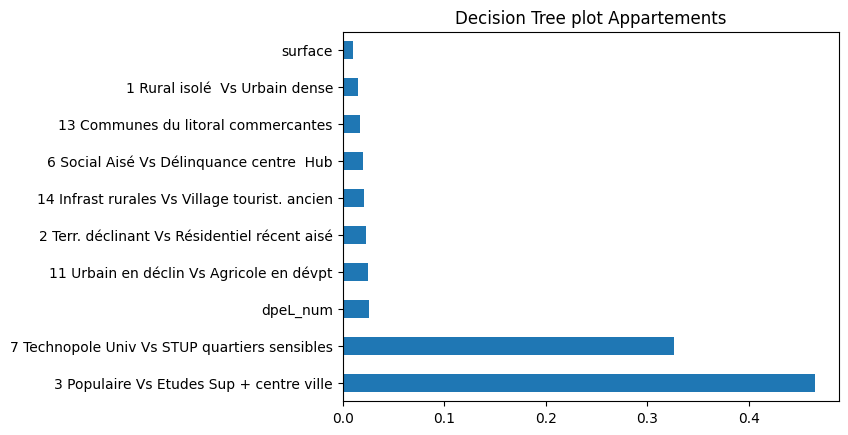

In [47]:
decision_tree = RegressionModels["DecisionTreeRegressor"]
if DecisionTreeDisplay :
    feat_importances = pd.Series(
        decision_tree.feature_importances_, X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh',title="Decision Tree plot Appartements")
    plt.show()

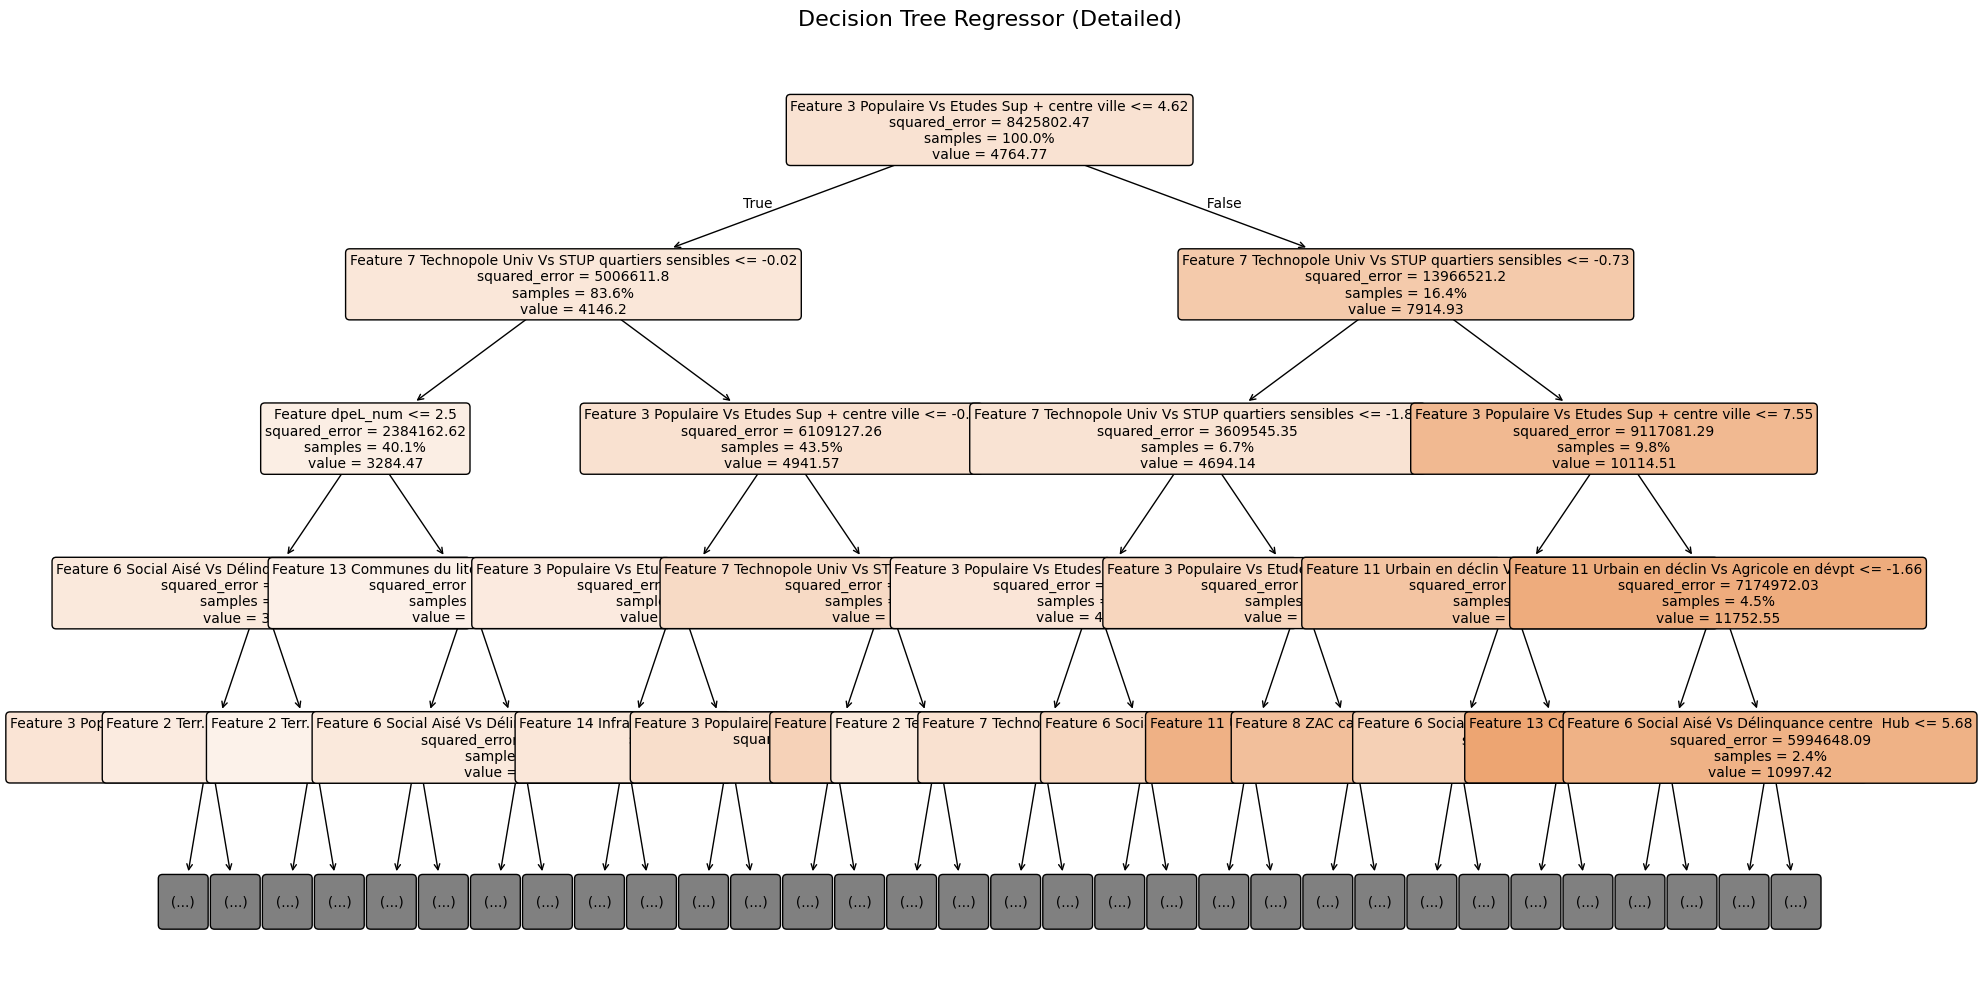

In [52]:
# Optional: More detailed visualization with additional parameters

if DecisionTreeDisplay :

    plt.figure(figsize=(20, 10))
    plot_tree(decision_tree, 
            feature_names=[f'Feature {name}' for name in X.columns],
            max_depth =4,
            filled=True,
            rounded=True,
            fontsize=10,
            proportion=True,  # Show proportion of samples
            precision=2)      # Decimal precision

    plt.title("Decision Tree Regressor (Detailed)", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Shap interpretation of XGBRegressor

In [53]:
def interpret_results_with_shap (model_name, model,X_test) :

    print ("Shap for model ",model_name)

    y_pred = model.predict(X_test)
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    print ("shap explainer starts...")
    shap_values = explainer(X_test)
    print ("shap explainer ends ...")

    print("="*60)
    print("SHAP INTERPRETATION GUIDE")
    print("="*60)
    print("""
    SHAP values explain how each feature contributes to predictions:
    - Positive SHAP value → feature pushes prediction HIGHER
    - Negative SHAP value → feature pushes prediction LOWER
    - Magnitude → strength of the feature's impact

    Base value: average model prediction across training data
    Prediction = Base value + sum of SHAP values for all features
    """)

    return explainer, shap_values, y_pred

def shap_summary_plot (shap_values) :
    # ==============================================================================
    # 1. SUMMARY PLOT - Feature Importance Overview
    # ==============================================================================
    print("\n1. SUMMARY PLOT (Feature Importance)")
    print("-" * 60)
    print("Shows:")
    print("  • Which features are most important globally")
    print("  • Distribution of SHAP values for each feature")
    print("  • Color: feature value (red=high, blue=low)")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    plt.show()

def shap_bar_plot (shap_values) :
    # ==============================================================================
    # 2. BAR PLOT - Mean Absolute SHAP Values
    # ==============================================================================
    print("\n2. BAR PLOT (Mean Feature Importance)")
    print("-" * 60)
    print("Shows average impact magnitude of each feature")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()

def shap_dependency_plot (shap_values,feature1,feature2,feature3) :
    # ==============================================================================
    # 3. DEPENDENCE PLOTS - Feature Effects
    # ==============================================================================
    print("\n3. DEPENDENCE PLOTS (Individual Feature Effects)")
    print("-" * 60)
    print("Shows how a feature's value affects predictions")
    print("Color shows interaction with another feature")

    # Plot for most important features
    important_features = [feature1, feature2, feature3]
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    for idx, feature in enumerate(important_features):
        plt.sca(axes[idx])
        shap.dependence_plot(feature, shap_values.values, X_test, 
                            show=False, ax=axes[idx])
    plt.tight_layout()
    plt.show()

def shap_waterfall_plot (shap_values, y_pred) :

    # ==============================================================================
    # 4. WATERFALL PLOT - Single Prediction Explanation
    # ==============================================================================
    print("\n4. WATERFALL PLOT (Single Prediction Breakdown)")
    print("-" * 60)
    print("Shows how features contribute to ONE specific prediction")
    print("Reading from bottom to top:")
    print("  • Starts at base value (average prediction)")
    print("  • Each bar shows a feature's contribution")
    print("  • Ends at the final prediction")

    sample_idx = 0
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_values[sample_idx], show=False)
    plt.tight_layout()
    plt.show()

    # Print numerical breakdown
    print(f"\nPrediction breakdown for sample {sample_idx}:")
    print(f"Base value: {shap_values[sample_idx].base_values:.4f}")
    for i, feature in enumerate(X_test.columns):
        print(f"{feature:12s}: {shap_values[sample_idx].values[i]:+.4f} "
            f"(feature value: {X_test.iloc[sample_idx][feature]:.4f})")
    print(f"{'Final pred':12s}: {y_pred[sample_idx]:.4f}")
    print(f"{'Actual':12s}: {y_test.iloc[sample_idx]:.4f}")


def shap_force_plot ( explainer, shap_values, X_test) :
    # ==============================================================================
    # 5. FORCE PLOT - Multiple Predictions
    # ==============================================================================
    print("\n5. FORCE PLOT (Visual Push/Pull of Features)")
    print("-" * 60)
    print("Red bars push prediction higher, blue bars push lower")

    shap.initjs()

    display(shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :]))

    shap.force_plot(explainer.expected_value, shap_values.values[70,:], X_test.iloc[70,:])

def shap_feature_interactions_plot (explainer, feature2,feature3) :
    # ==============================================================================
    # 6. FEATURE INTERACTIONS
    # ==============================================================================
    print("\n6. INTERACTION VALUES (Advanced)")
    print("-" * 60)
    print("Identifies which features interact with each other")

    # Calculate interaction values (can be slow for large datasets)
    shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:100])

    # Plot interaction for top feature
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        (feature2, feature3),
        shap_interaction_values,
        X_test.iloc[:100],
        show=False
    )
    plt.title(f"Interaction between {feature2} and {feature3}")
    plt.tight_layout()
    plt.show()



In [ ]:
# Create SHAP explainer
model_name = "XGBRegressor"
if ShapDisplay :
    model = RegressionModels[model_name]
    explainer, shap_values, y_pred = interpret_results_with_shap (model_name, model,X_test)


Shap for model  XGBRegressor
shap explainer starts...
shap explainer ends ...
SHAP INTERPRETATION GUIDE

    SHAP values explain how each feature contributes to predictions:
    - Positive SHAP value → feature pushes prediction HIGHER
    - Negative SHAP value → feature pushes prediction LOWER
    - Magnitude → strength of the feature's impact

    Base value: average model prediction across training data
    Prediction = Base value + sum of SHAP values for all features
    


In [69]:

explainer = load_model_file(app_shap_explainer_file,model_name,compression_extension)


1. SUMMARY PLOT (Feature Importance)
------------------------------------------------------------
Shows:
  • Which features are most important globally
  • Distribution of SHAP values for each feature
  • Color: feature value (red=high, blue=low)


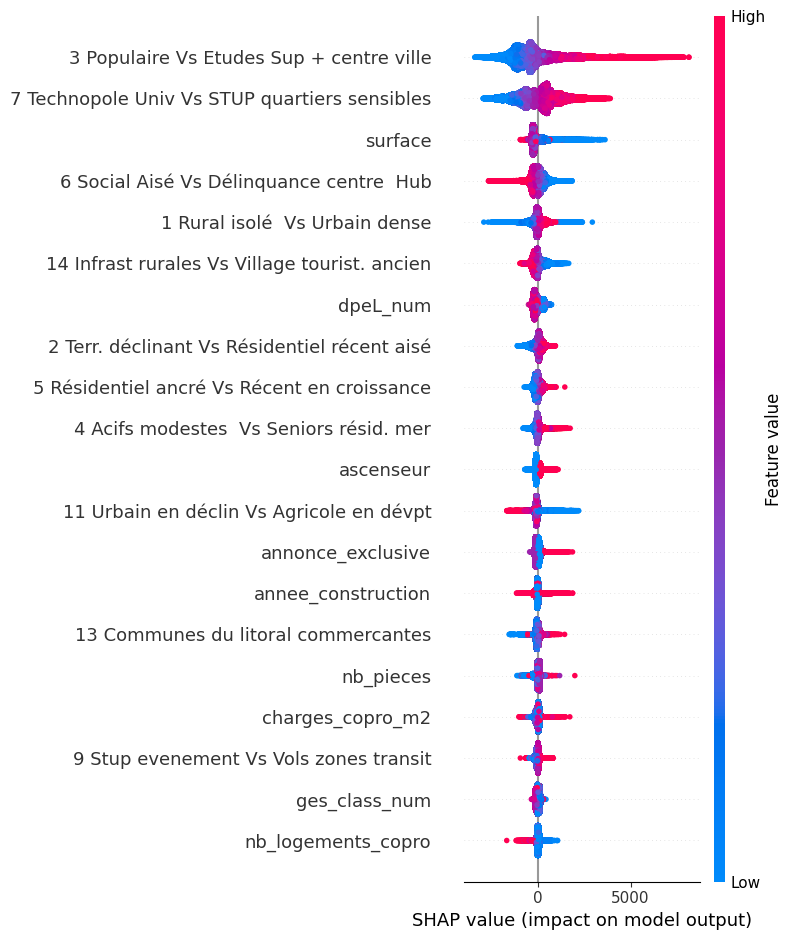


2. BAR PLOT (Mean Feature Importance)
------------------------------------------------------------
Shows average impact magnitude of each feature


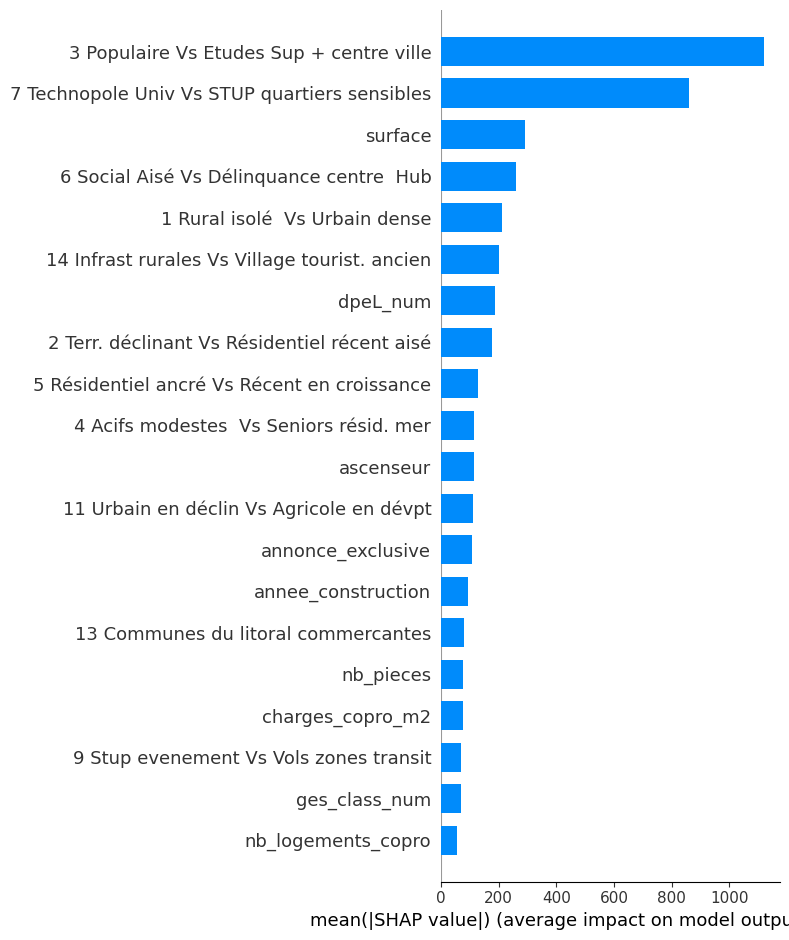


3. DEPENDENCE PLOTS (Individual Feature Effects)
------------------------------------------------------------
Shows how a feature's value affects predictions
Color shows interaction with another feature


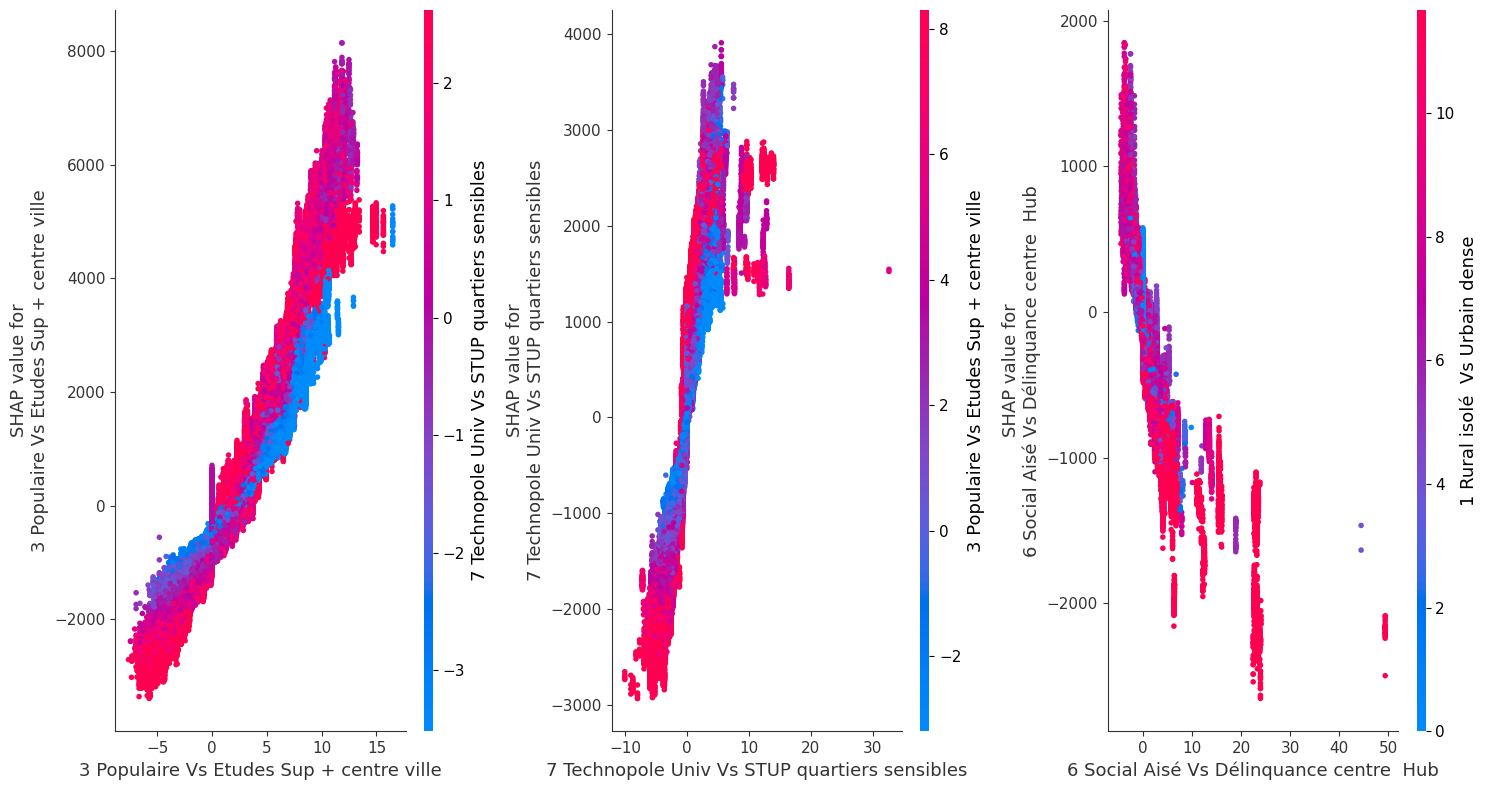


4. WATERFALL PLOT (Single Prediction Breakdown)
------------------------------------------------------------
Shows how features contribute to ONE specific prediction
Reading from bottom to top:
  • Starts at base value (average prediction)
  • Each bar shows a feature's contribution
  • Ends at the final prediction


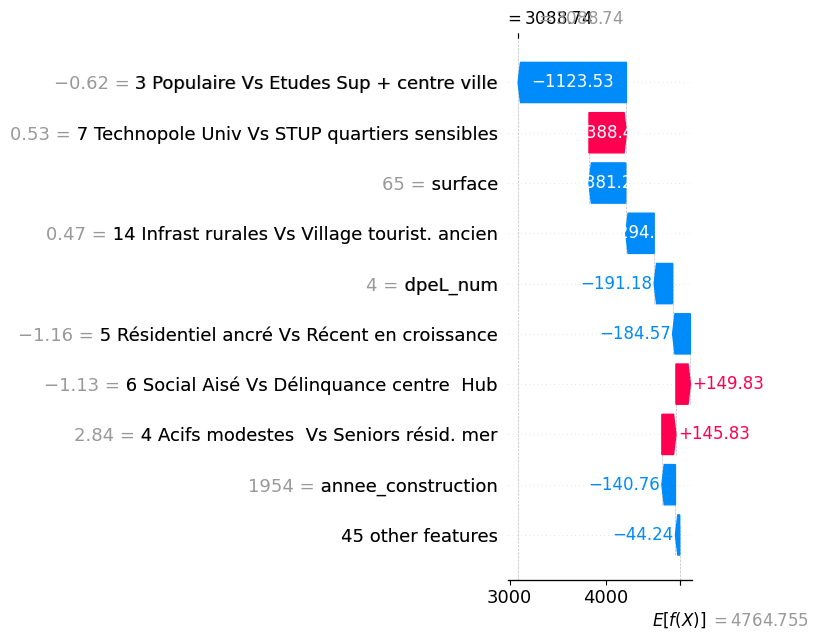


Prediction breakdown for sample 0:
Base value: 4764.7549
etage       : +10.7708 (feature value: 0.0000)
surface     : -381.2667 (feature value: 65.0000)
nb_pieces   : +4.8434 (feature value: 4.0000)
balcon      : +6.5442 (feature value: 0.0000)
eau         : +19.7705 (feature value: 1.0000)
bain        : +4.5640 (feature value: 0.0000)
annonce_exclusive: +36.7162 (feature value: 0.0000)
nb_etages   : +4.5801 (feature value: 4.0000)
places_parking: +21.6202 (feature value: 1.0000)
cave        : -32.7183 (feature value: 1.0000)
annee_construction: -140.7586 (feature value: 1954.0000)
nb_toilettes: -13.2590 (feature value: 1.0000)
nb_terraces : +0.0000 (feature value: 0.0000)
videophone  : -2.4451 (feature value: 0.0000)
porte_digicode: -16.7316 (feature value: 0.0000)
ascenseur   : -77.0789 (feature value: 0.0000)
nb_logements_copro: +33.1302 (feature value: 50.0000)
logement_neuf: +0.0658 (feature value: 0.0000)
charges_copro_m2: +3.8938 (feature value: 38.2957)
dpeL_num    : -191.1763


6. INTERACTION VALUES (Advanced)
------------------------------------------------------------
Identifies which features interact with each other


<Figure size 1000x600 with 0 Axes>

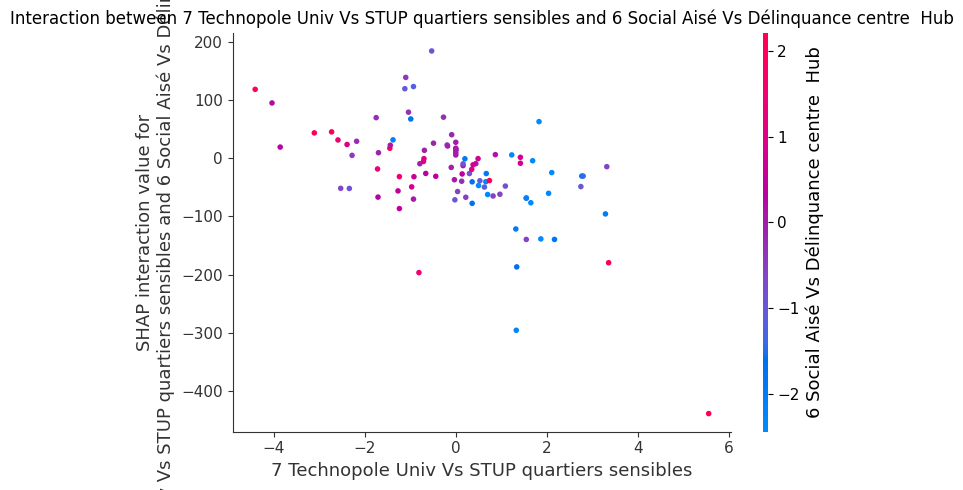

In [70]:
if AddACP :
    feature1 = "PC3"
    feature2 = "PC7"
    feature3 = "PC6"

    feature1 = ACPS[feature1]
    feature2 = ACPS[feature2]
    feature3 = ACPS[feature3]
else :
    feature1 = "charges_copro_m2"
    feature2 = "porte_digicode"
    feature3 = "nb_etages"

shap_summary_plot(shap_values)

shap_bar_plot(shap_values)

shap_dependency_plot(shap_values,feature1,feature2,feature3)

shap_waterfall_plot(shap_values,y_pred)

shap_force_plot(explainer,shap_values,X_test)

shap_feature_interactions_plot(explainer,feature2,feature3)





3. DEPENDENCE PLOTS (Individual Feature Effects)
------------------------------------------------------------
Shows how a feature's value affects predictions
Color shows interaction with another feature


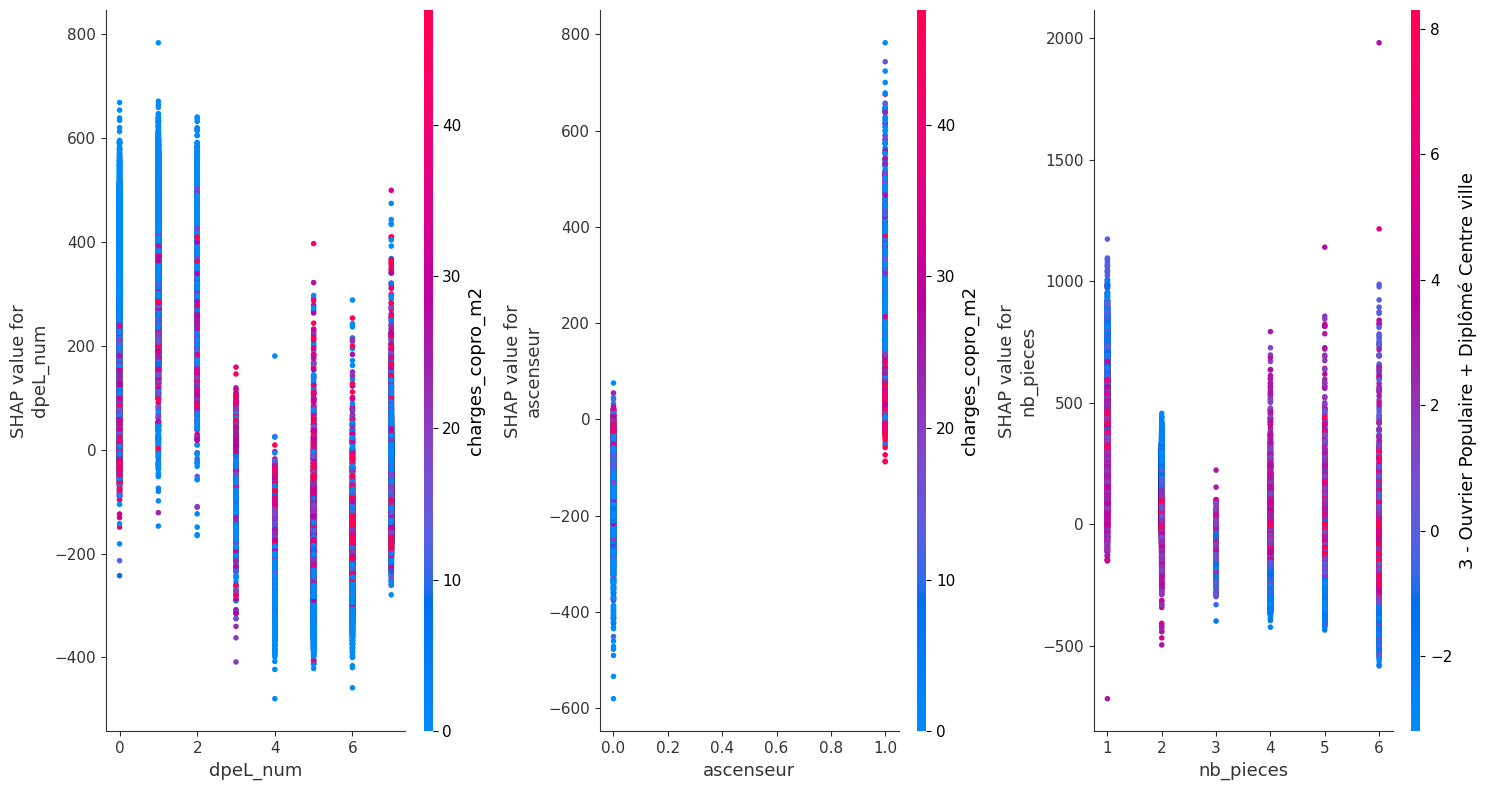

In [162]:
feature1 ="dpeL_num"
feature2 = "ascenseur"
feature3 = "nb_pieces"
shap_dependency_plot(shap_values,feature1,feature2,feature3)

In [ ]:
# ==============================================================================
# 3. DEPENDENCE PLOTS - Feature Effects
# ==============================================================================
print("\n3. DEPENDENCE PLOTS (Individual Feature Effects)")
print("-" * 60)
print("Shows how a feature's value affects predictions")
print("Color shows interaction with another feature")

feature1 = "surface"
feature2 = "PC3"
feature3 = "PC7"
# Plot for most important features
important_features = [feature1, feature2, feature3]
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for idx, feature in enumerate(important_features):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, shap_values.values, X_test, 
                        show=False, ax=axes[idx])
plt.tight_layout()
plt.show()
